# t-SNE Attribution Tutorial

In this tutorial we go over a very simple example to demonstrate the ideas behind this method

In [1]:
import os

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import animation
from numpy.random import rand
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import HTML
import sklearn
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import squareform

from interpretable_tsne import tsne
from interpretable_tsne.tsne import TSNE

os.chdir('..')
from src.set_up_sim_data import gen_sim_data_4_clusters

In [2]:
%matplotlib

Using matplotlib backend: agg


In this tutorial, we will apply our t-SNE attribution to retrieve the significant features of a simple synthetically generated dataset.

We generate synthetic data using the same function we used in our manuscript.

The data is generated using a 10 dimensional standard normal with certain features of certain classes being translated.

Our data has 4 classes with the following hierarchical structure:
* Class A: Feat 1 and 2 are enriched (translated along the respective axis) by 4 and 3 respectively.
* Class B: Feat 1 is enriched by 4
* Class C: Feat 3 is enriched by 3
* Class D: No feature enrichment

We expect:
* The attribution for feature 1 is large for each class. 
* High attribution for feature 2 for samples in Class A and B (since it seperates the two)
* High attribution for feature 3 for samples in Class C and D (since it seperates the two)

In [3]:
data, classes = gen_sim_data_4_clusters(seed=20, effect_size_main=4, effect_size_subgroups=3, size=2000)
classes = pd.Categorical(classes).rename_categories({i:c for i,c in enumerate(['A', 'B', 'C', 'D'])})

In [4]:
colors = plt.get_cmap("tab10")
col_dict = {c:colors.colors[i] for i,c in enumerate(['A', 'B', 'C', 'D'])}
colors = [col_dict[c] for c in classes]

Lets plot the first 3 dimensions (features) of our data and color these by their classes.

We can see the structure that we hope our attribution method will retrieve.

In [5]:
# code taken from: https://stackoverflow.com/questions/33436221/displaying-rotatable-3d-plots-in-ipython-or-jupyter-notebook
fig = plt.figure(dpi=50)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:,0], data[:,1], data[:,2], color=colors)

ax.set_xlabel('Feat 1')
ax.set_ylabel('Feat 2')
ax.set_zlabel('Feat 3')

def animate(frame):
    ax.view_init(30, frame/4)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

Lets perform a PCA on the first 3 dimensions of the data.

We can see that the 4 clusters are mostly seperated.

In [6]:
pca_obj = PCA(n_components=2)
pca_data = pca_obj.fit_transform(data[:,:3])

/lustre06/project/6065672/sciclun4/Envs/test_env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


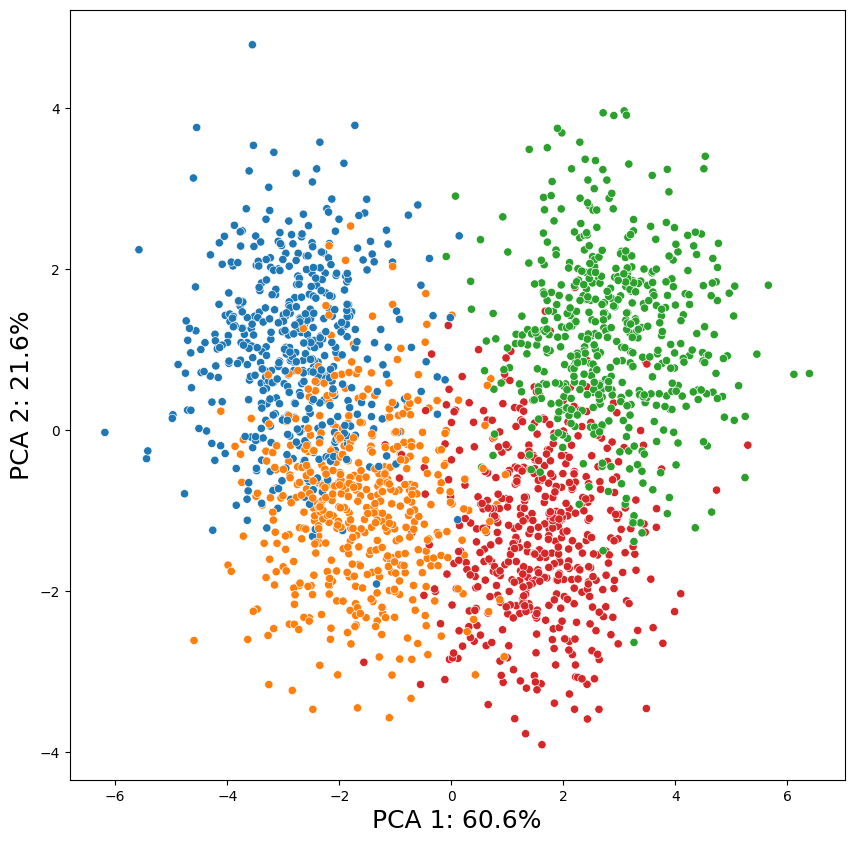

In [7]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
_ = sns.scatterplot(pca_data[:,0], pca_data[:,1], hue=classes, palette=col_dict, ax=ax)
_ = ax.set_xlabel('PCA 1: {:.1f}%'.format(pca_obj.explained_variance_ratio_[0]*100), fontsize=18)
_ = ax.set_ylabel('PCA 2: {:.1f}%'.format(pca_obj.explained_variance_ratio_[1]*100), fontsize=18)
ax.get_legend().remove()

Now lets see what our PCA plane looks like overlayed on our data in the 3D ambient space.

We plot the PC projection of each point (usual coloring) along with the 3D point (transparant coloring).

This linear manifold represents the data fairly well.

In [8]:
projected_data = pca_obj.inverse_transform(pca_data)

In [9]:
# Computing plane from: https://stackoverflow.com/questions/49957601/how-can-i-draw-3d-plane-using-pca-in-python
pca_obj_full = PCA(n_components=3)
pca_data = pca_obj_full.fit_transform(data[:,0:3])
eig_vec = pca_obj_full.components_

# [0.90946569 0.08816839 0.00236591]
# Percentage of variance explain by last vector is less 0.2%

# This is the normal vector of minimum variance
normal = eig_vec[2, :]  # (a, b, c)
centroid = np.mean(data[:,0:3], axis=0)

# Every point (x, y, z) on the plane should satisfy a*x+b*y+c*z = d
# Taking centroid as a point on the plane
d = -centroid.dot(normal)

# Draw plane
xx, yy = np.meshgrid(np.arange(np.min(data[:, 0]), 
                               np.max(data[:, 0])), 
                     np.arange(np.min(data[:, 1]), 
                               np.max(data[:, 1]))
                    )

zz = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

In [10]:
%matplotlib
fig = plt.figure(dpi=50)
ax = fig.add_subplot(111, projection='3d')

# plot the surface
ax.plot_surface(xx, yy, zz, alpha=0.5)

ax.scatter(data[:,0], data[:,1], data[:,2], color=colors, alpha=0.1)
ax.scatter(projected_data[:,0], projected_data[:,1], projected_data[:,2], color=colors, alpha=1)
    
ax.set_xlabel('Feat 1')
ax.set_ylabel('Feat 2')
ax.set_zlabel('Feat 3')
_ = ax.set_zlim(projected_data[:,2].min(), projected_data[:,2].max())

def animate(frame):
    ax.view_init(30, frame/4)
    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=200, interval=50)
HTML(anim.to_html5_video())

Using matplotlib backend: agg


## t-SNE Plotting

One of the first steps of t-SNE is to compute the affinity matrix $P$. We plot it here.

In [11]:
data_reordered = np.concatenate([data[classes=='A'], data[classes=='B'], data[classes=='C'], data[classes=='D']])
class_size = len(data_reordered)//4
classes_reordered = pd.Categorical(['A']*class_size + ['B']*class_size + ['C']*class_size + ['D']*class_size)

In [12]:
distances = pairwise_distances(data_reordered[:,:3], metric='euclidean', squared=True)
P, _, _ = tsne._joint_probabilities(distances, desired_perplexity=30, verbose=False)

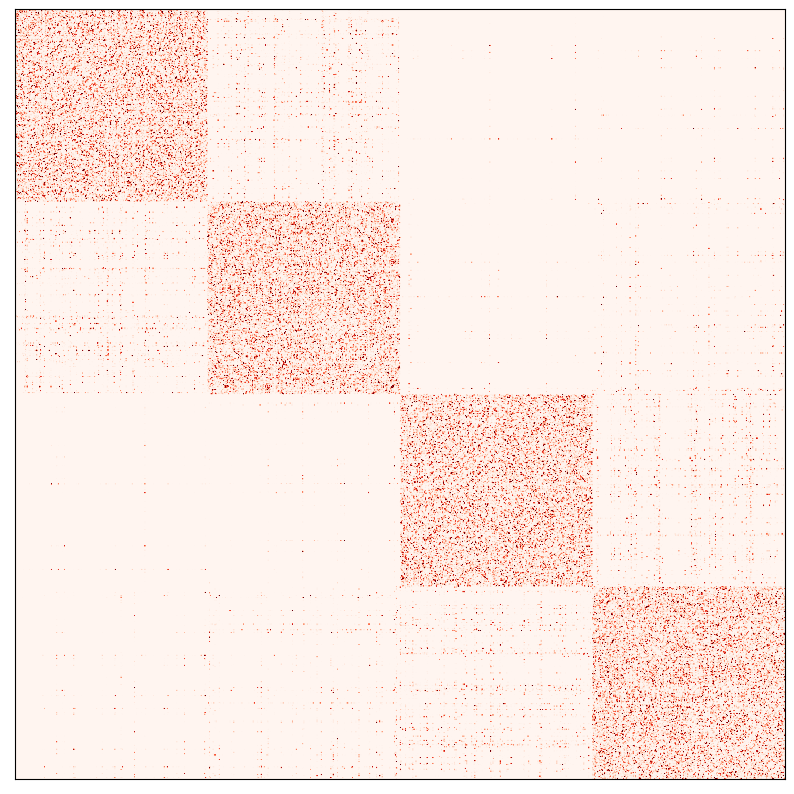

In [13]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(squareform(P), cmap="Reds", vmin=0, vmax=np.percentile(P, 99))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

This function will compute the $Q$ matrix per iteration (given the embeddings)

In [14]:
def get_affinities(embedding):
    distances = pairwise_distances(embedding, metric='euclidean', squared=True)
    D = 1 / (1 + distances**2)
    Q = D / (D - np.eye(D.shape[0])).sum()
    np.fill_diagonal(Q, 0, wrap=False) 
    return Q

We use our function to compute t-SNE embeddings along with attributions.

We use the `checkpoint_every` argument to specify that we want attributions at every step.

Note here we are using `grad_norm` attribution. This means we are taking the gradient with respect to the gradient norm (of the embeddings).

In [15]:
seed_value = 42  # set the random seed

import os
os.environ['PYTHONHASHSEED'] = str(seed_value)
# 2. Set `python` built-in pseudo-random generator at a fixed value

import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

tsne_obj = TSNE(perplexity=30, 
                early_exaggeration=4,
                n_iter=1000,
                learning_rate=500,
                random_state=seed_value,
                checkpoint_every=list(np.arange(0, 1000)),
                attr='grad_norm',
                init='random',
                method='barnes_hut')

out = tsne_obj.fit_transform(data_reordered)

We compute the affinities (Q) after each step using the embeddings returned by our algorithm.

In [16]:
embeddings = out['embeddings']
affinities_embs = []

for embedding in embeddings:
    affinities_emb = get_affinities(embedding)
    affinities_embs.append(affinities_emb)

The t-SNE looks pretty good.

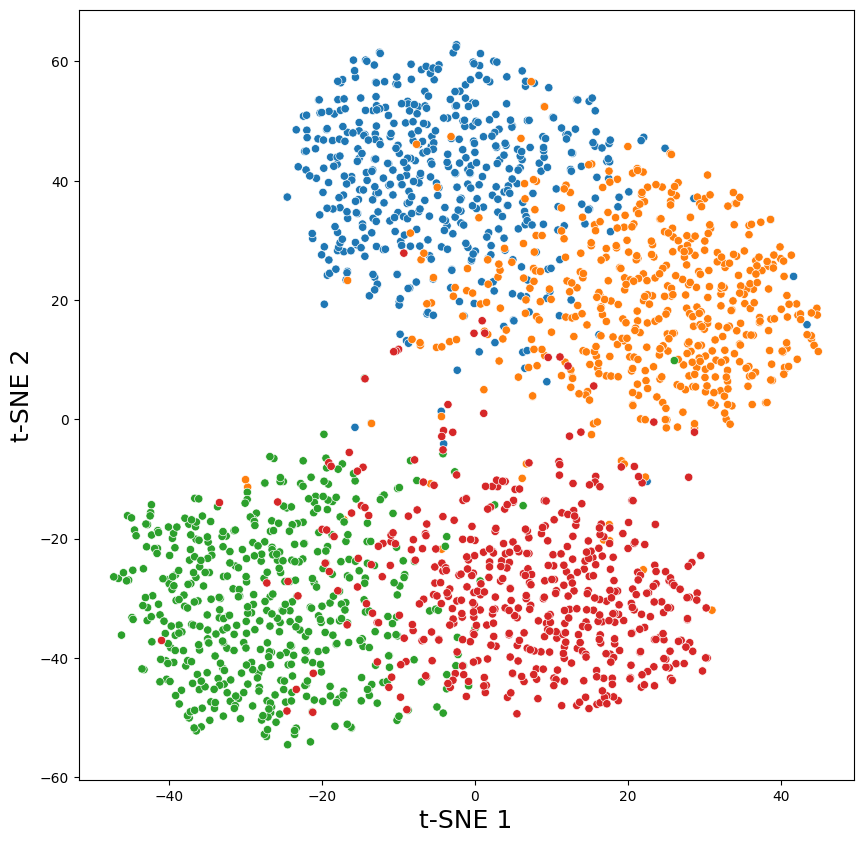

In [17]:
fig, ax = plt.subplots(figsize=(10,10))
data_emb = pd.DataFrame({'t-SNE 1': embeddings[-1][:,0],
                         't-SNE 2': embeddings[-1][:,1],
                         'target': classes_reordered})
_ = sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='target', data=data_emb, palette=col_dict, ax=ax)
_ = ax.set_xlabel('t-SNE 1', fontsize=18)
_ = ax.set_ylabel('t-SNE 2', fontsize=18)
ax.get_legend().remove()

We can now confirm that over the duration of t-SNE, the affinties matrix of the embeddings begins to look very similar to the affinities computed on the input data.

In [18]:
max_axis_display = np.maximum.accumulate(np.abs(np.stack(embeddings)).max(1), 0)

In [19]:
%matplotlib

fig, ax = plt.subplots(ncols=2, figsize=(20,10), dpi=50)

def animate(frame):
    ax[0].cla()
    ax[1].cla()

    data_emb = pd.DataFrame({'t-SNE 1': embeddings[frame][:,0],
                             't-SNE 2': embeddings[frame][:,1],
                             'target': classes_reordered})
    _ = sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='target', data=data_emb, palette=col_dict, ax=ax[0])
    _ = ax[0].set_xlabel('t-SNE 1', fontsize=18)
    _ = ax[0].set_ylabel('t-SNE 2', fontsize=18)
    xmax = max_axis_display[frame, 0]
    ymax = max_axis_display[frame, 1]
    ax[0].set_xlim(xmin=-xmax, xmax=xmax)
    ax[0].set_ylim(ymin=-ymax, ymax=ymax)
    ax[0].get_legend().remove()

    im = ax[1].imshow(affinities_embs[frame], cmap="Reds", vmin=0, vmax=np.percentile(affinities_embs[frame], 99))
    ax[1].get_xaxis().set_visible(False)
    ax[1].get_yaxis().set_visible(False)

    plt.pause(.001)
    return fig

anim = animation.FuncAnimation(fig, animate, frames=len(embeddings[:1000]), interval=50)
HTML(anim.to_html5_video())

Using matplotlib backend: agg


Finally, lets inspect the gradients.

We need to clean these up a bit before using them.

Lets set the nan's to 0 and set the ceiling to 1.

In [20]:
attrs = np.stack(out['attrs'])
attrs[np.isnan(attrs)] = 0
attrs[attrs > 1] = 1
attrs[attrs < -1] = -1

Now lets look at how the gradients change with the t-SNE.

We average the gradients of each feature within classes.

We see that the features that generated the heirarchical structures are the ones with the highest attribution, as expected.

Note that we only look at gradients up to step 250 since we found that the gradients computed during the early exaggeration phase were the ones best able to identify features relevent to overall global structure.

In [21]:
fig = plt.figure(figsize=(20, 10), dpi=50)
gs0 = fig.add_gridspec(1, 2)
gs00 = gs0[0]
gs01 = gs0[1].subgridspec(4, 1)

def animate(frame):
    plt.clf()

    ax = fig.add_subplot(gs00)
    data_emb = pd.DataFrame({'t-SNE 1': embeddings[frame][:,0],
                             't-SNE 2': embeddings[frame][:,1],
                             'target': classes_reordered})
    _ = sns.scatterplot(x='t-SNE 1', y='t-SNE 2', hue='target', data=data_emb, palette=col_dict, ax=ax)
    _ = ax.set_xlabel('t-SNE 1', fontsize=18)
    _ = ax.set_ylabel('t-SNE 2', fontsize=18)
    xmax = max_axis_display[frame, 0]
    ymax = max_axis_display[frame, 1]
    ax.set_xlim(xmin=-xmax, xmax=xmax)
    ax.set_ylim(ymin=-ymax, ymax=ymax)
    ax.get_legend().remove()

    avg_attrs = np.array([np.abs(attrs[frame][0][classes_reordered == 'A'].mean(0)),
                          np.abs(attrs[frame][0][classes_reordered == 'B'].mean(0)),
                          np.abs(attrs[frame][0][classes_reordered == 'C'].mean(0)),
                          np.abs(attrs[frame][0][classes_reordered == 'D'].mean(0))])

    for i in range(4):
        ax = fig.add_subplot(gs01[i])
        sns.barplot(x=np.arange(avg_attrs.shape[1]), y=avg_attrs[i], ax=ax, color='grey')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    return fig

anim = animation.FuncAnimation(fig, animate, frames=len(embeddings[:250]), interval=50)
HTML(anim.to_html5_video())